# Traffic Forecasting (Beginner)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from prophet import Prophet

In [2]:
# loading the dataset
df = pd.read_csv('./data/TrafficDataTimeSeriesAnalysis.csv')
df.head()

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2


# Preprocessing data

In [3]:
# checking for null rows
df.isnull().sum()

ID          0
Datetime    0
Count       0
dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18288 entries, 0 to 18287
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        18288 non-null  int64 
 1   Datetime  18288 non-null  object
 2   Count     18288 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 428.8+ KB


Number of rows: 18288 entries.

The Datetime column is of data type 'object', we must convert it.

In [5]:
# Datetime format: 25-08-2012 00:00 (dd-mm-YYYY HH:MM)
df['Datetime'] = pd.to_datetime(df['Datetime'], format='%d-%m-%Y %H:%M')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18288 entries, 0 to 18287
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   ID        18288 non-null  int64         
 1   Datetime  18288 non-null  datetime64[ns]
 2   Count     18288 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 428.8 KB


# EDA

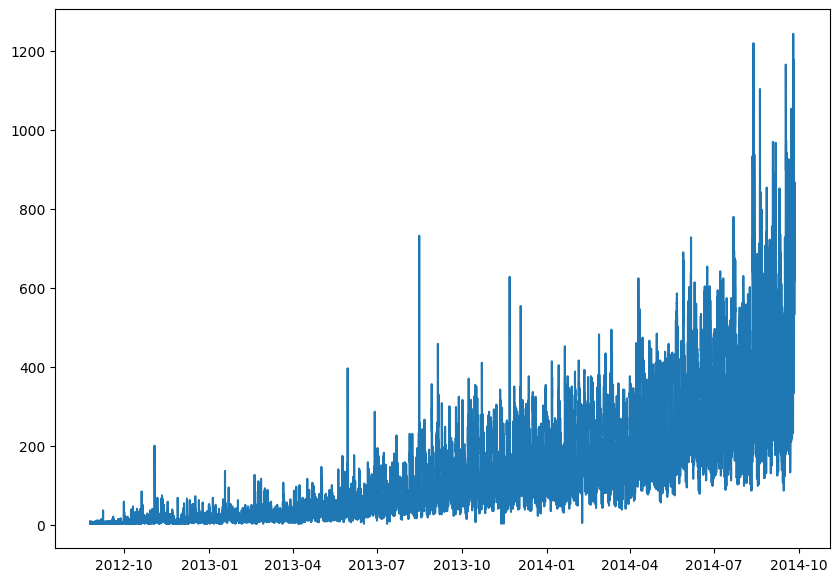

In [6]:
plt.figure(figsize=(10,7))
plt.plot(df['Datetime'], df['Count'])

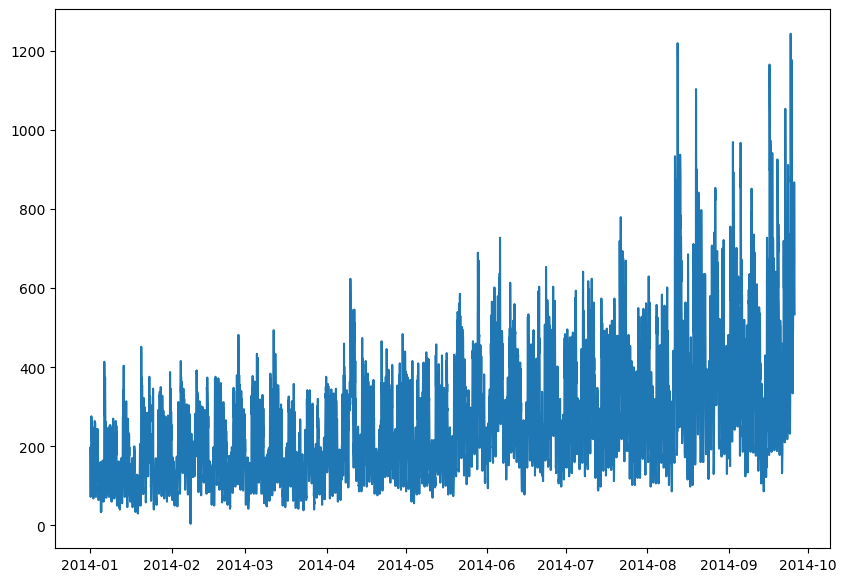

In [7]:
# Filter the DataFrame for records from 2014 onwards
df_filtered = df[df['Datetime'] >= '2014-01-01 00:00']

plt.figure(figsize=(10,7))
plt.plot(df_filtered['Datetime'], df_filtered['Count'])

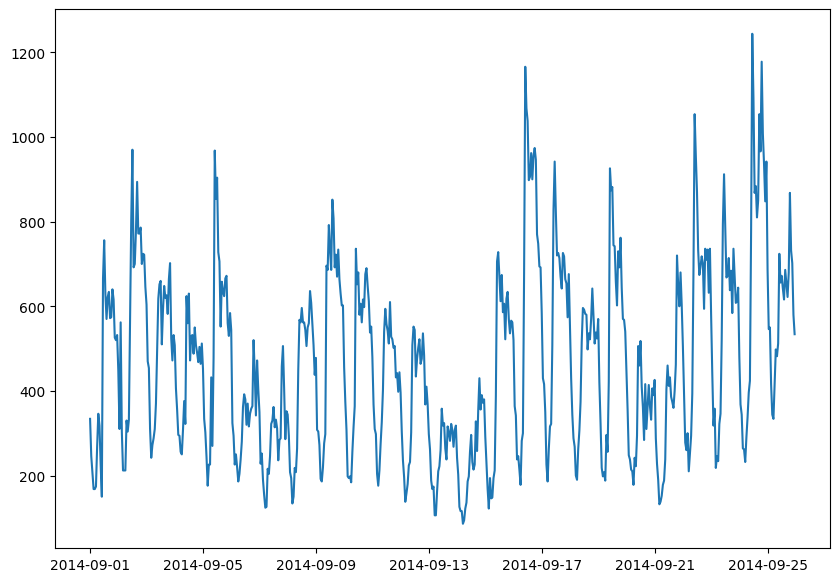

In [8]:
# Filter the DataFrame for records from 2014 onwards
df_filtered = df[df['Datetime'] >= '2014-09-01 00:00']

plt.figure(figsize=(10,7))
plt.plot(df_filtered['Datetime'], df_filtered['Count'])

# Format data for the model

In [9]:
df.index = df['Datetime']
df['y'] = df['Count']
df.drop(columns=['ID', 'Datetime', 'Count'], axis=1, inplace=True)
# grouping by the index by Day and summing all the rows.
df = df.resample('D').sum()
df.head()

,y
Datetime,
2012-08-25,76
2012-08-26,88
2012-08-27,62
2012-08-28,58
2012-08-29,60


In [10]:
df['ds'] = df.index
df.head()

,y,ds
Datetime,,
2012-08-25,76,2012-08-25
2012-08-26,88,2012-08-26
2012-08-27,62,2012-08-27
2012-08-28,58,2012-08-28
2012-08-29,60,2012-08-29


## Input Split

In [11]:
size = 60
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=size/len(df), shuffle=False)

In [12]:
train.tail()

,y,ds
Datetime,,
2014-07-23,10130,2014-07-23
2014-07-24,8156,2014-07-24
2014-07-25,7192,2014-07-25
2014-07-26,6562,2014-07-26
2014-07-27,6094,2014-07-27


In [13]:
test.head()

,y,ds
Datetime,,
2014-07-28,8546,2014-07-28
2014-07-29,8218,2014-07-29
2014-07-30,8498,2014-07-30
2014-07-31,8740,2014-07-31
2014-08-01,9186,2014-08-01


In [14]:
test.tail(2)

,y,ds
Datetime,,
2014-09-24,16856,2014-09-24
2014-09-25,14152,2014-09-25


# Metrics to Evaluate Model
1. Mean Absolute Error (MAE)
2. Root Mean Squared Error (RMSE)
3. Mean Absolute Percentage Error (MAPE)
4. 

# Model Training


## Model: Linear Regression

In [ ]:
# WIP

## Model: Decision Trees

In [ ]:
# WIP

## Model: Random Forests

In [15]:
from sklearn.ensemble import RandomForestRegressor

In [16]:
# Extract features from the 'ds' column
train['year'] = train['ds'].dt.year
train['month'] = train['ds'].dt.month
train['day'] = train['ds'].dt.day
train['day_of_week'] = train['ds'].dt.dayofweek

test['year'] = test['ds'].dt.year
test['month'] = test['ds'].dt.month
test['day'] = test['ds'].dt.day
test['day_of_week'] = test['ds'].dt.dayofweek

# Prepare the feature set (X) and target variable (y)
X_train = train[['year', 'month', 'day', 'day_of_week']]
X_test = test[['year', 'month', 'day', 'day_of_week']]
y_train = train['y']

In [17]:
rf_regressor1 = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=23, verbose=1, criterion='friedman_mse', oob_score=True)
rf_regressor1.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


RandomForestRegressor(criterion='friedman_mse', max_depth=10, oob_score=True,
                      random_state=23, verbose=1)

In [18]:
rf_predicted_train = rf_regressor1.predict(X_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


## Model: Prophet

In [19]:
model = Prophet(yearly_seasonality=True, seasonality_prior_scale=0.9)
model.fit(train)

13:55:12 - cmdstanpy - INFO - Chain [1] start processing
13:55:12 - cmdstanpy - INFO - Chain [1] done processing


In [20]:
# forecasting for a period of 60 days (since the data frame for each row is in-terms of day)
future = model.make_future_dataframe(periods=60)
future

,ds
0,2012-08-25
1,2012-08-26
2,2012-08-27
3,2012-08-28
4,2012-08-29
...,...
757,2014-09-21
758,2014-09-22
759,2014-09-23
760,2014-09-24


In [21]:
forecast = model.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2012-08-25,-476.485324,-1778.948902,200.010207,-476.485324,-476.485324,-342.722218,-342.722218,-342.722218,-846.193710,-846.193710,-846.193710,503.471492,503.471492,503.471492,0.0,0.0,0.0,-819.207542
1,2012-08-26,-469.473226,-1897.057438,-18.367365,-469.473226,-469.473226,-458.413195,-458.413195,-458.413195,-967.165877,-967.165877,-967.165877,508.752683,508.752683,508.752683,0.0,0.0,0.0,-927.886421
2,2012-08-27,-462.461129,-492.477998,1378.609119,-462.461129,-462.461129,943.764348,943.764348,943.764348,431.216364,431.216364,431.216364,512.547984,512.547984,512.547984,0.0,0.0,0.0,481.303219
3,2012-08-28,-455.449031,-432.403355,1476.768816,-455.449031,-455.449031,954.544700,954.544700,954.544700,439.575750,439.575750,439.575750,514.968950,514.968950,514.968950,0.0,0.0,0.0,499.095669
4,2012-08-29,-448.436934,-439.259596,1481.215747,-448.436934,-448.436934,915.897573,915.897573,915.897573,399.763598,399.763598,399.763598,516.133975,516.133975,516.133975,0.0,0.0,0.0,467.460639


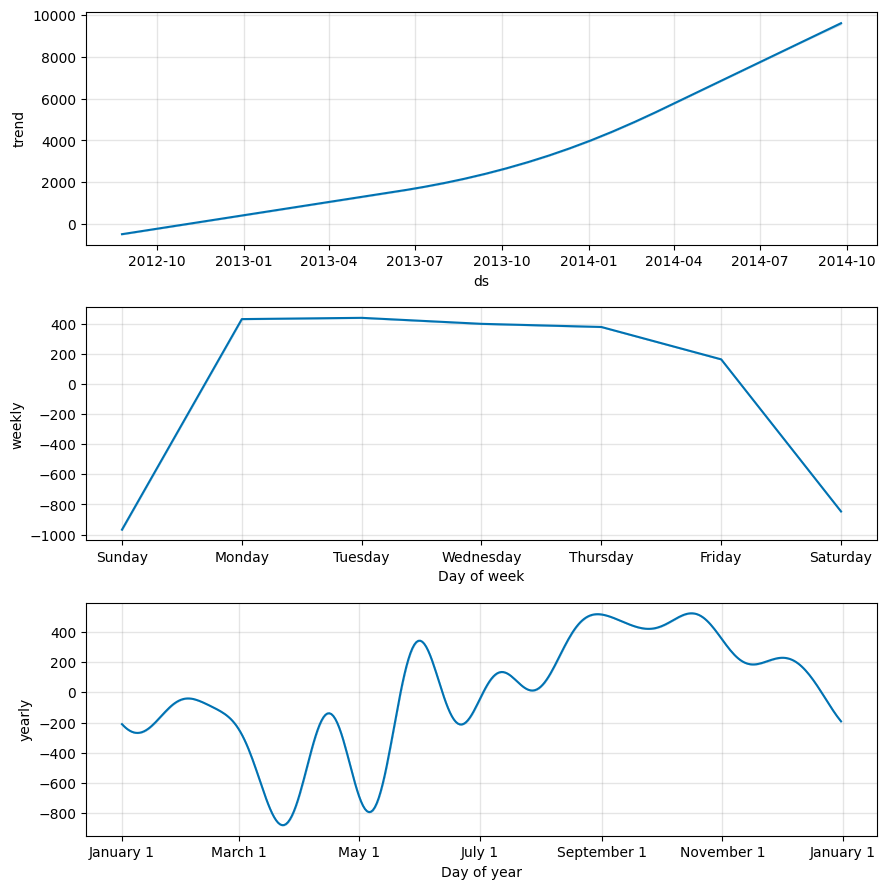

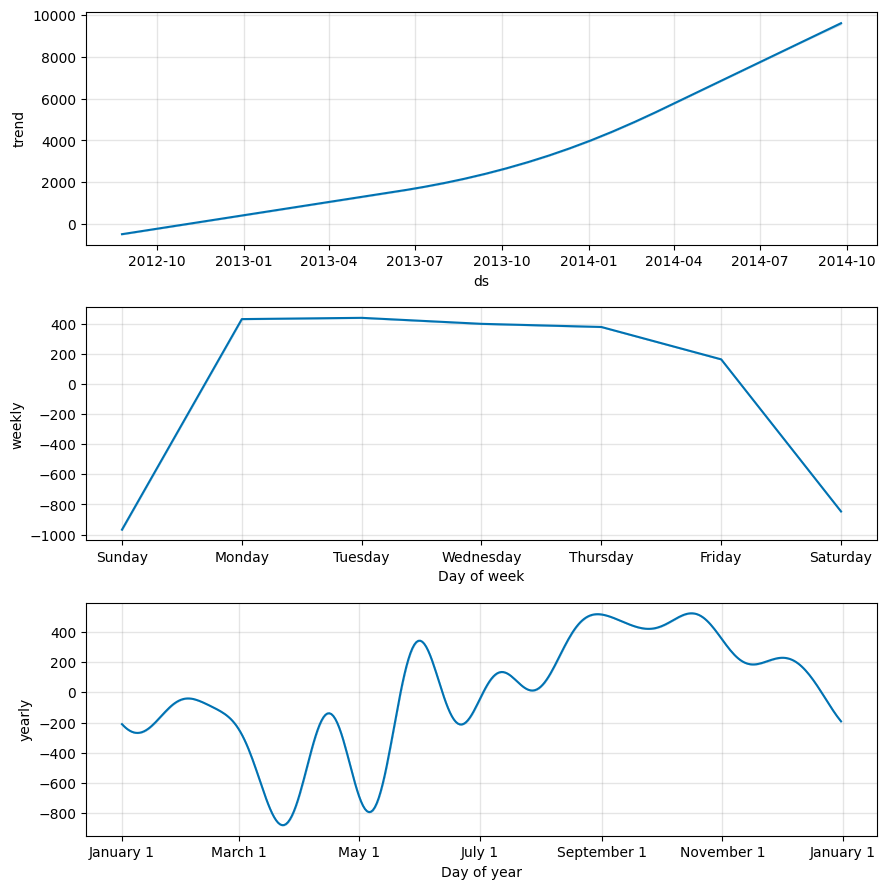

In [22]:
model.plot_components(forecast)

In [23]:
pred = forecast.iloc[-60:, :]
len(pred)

60

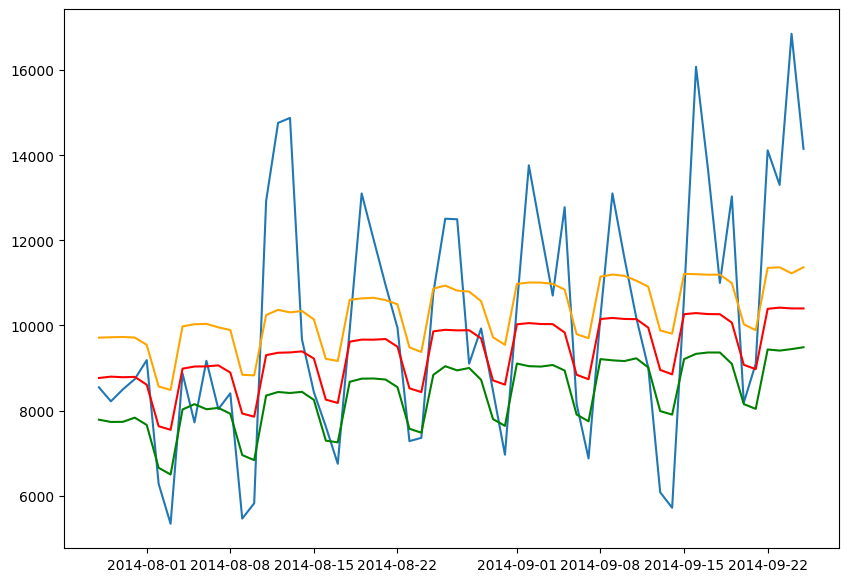

In [24]:
# plotting the test results
plt.figure(figsize=(10,7))
plt.plot(test['ds'], test['y'])
plt.plot(pred['ds'], pred['yhat'], color='red')
plt.plot(pred['ds'], pred['yhat_lower'], color='green')
plt.plot(pred['ds'], pred['yhat_upper'], color='orange')
plt.show()


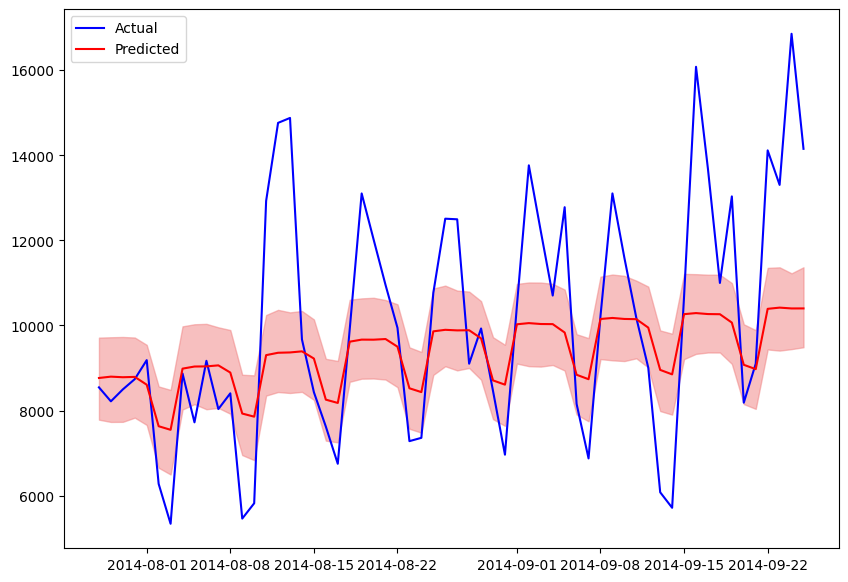

In [25]:
plt.figure(figsize=(10,7))
plt.plot(test['ds'], test['y'], label='Actual', color='blue')  # Added label for actual values
plt.plot(pred['ds'], pred['yhat'], color='red', label='Predicted')  # Predicted values in red
plt.fill_between(pred['ds'], pred['yhat_lower'], pred['yhat_upper'], color='lightcoral', alpha=0.5)  # Light red shading
plt.legend()  # Show legend
plt.show()

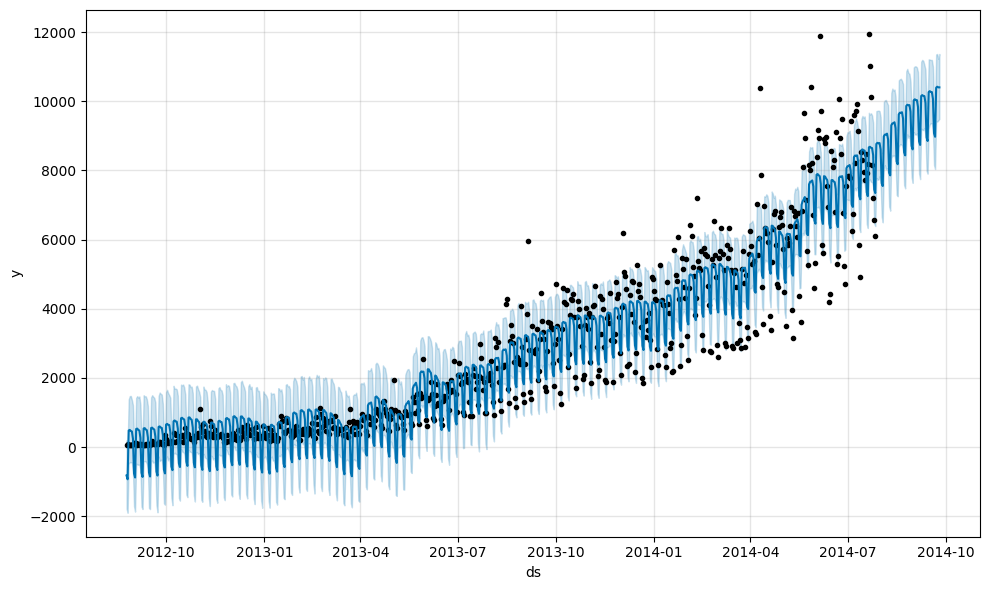

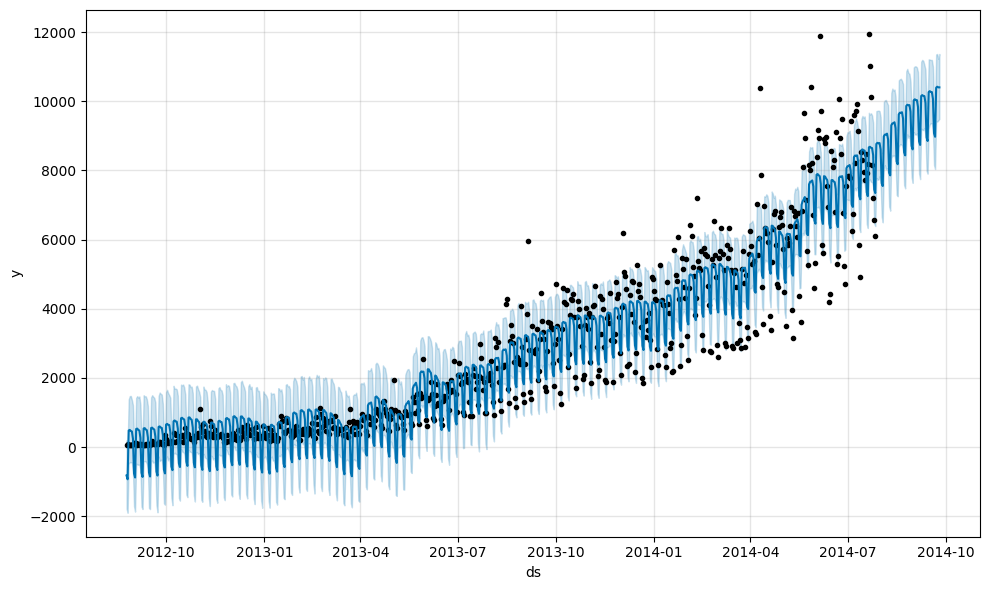

In [26]:
model.plot(forecast)

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['y'], pred['yhat']))
print(f'RMSE: {rmse}')

# Calculate MAE
mae = mean_absolute_error(test['y'], pred['yhat'])
print(f'MAE: {mae}')

# Calculate R-squared
r2 = r2_score(test['y'], pred['yhat'])
print(f'R-squared: {r2}')

RMSE: 2349.5920654854585
MAE: 1745.595508450399
R-squared: 0.29496066201459403


## Hyperparameter Tuning

In [28]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error

# Define the parameter grid for tuning
param_grid = {
    'yearly_seasonality': [True],
    'seasonality_prior_scale': [0.1, 0.7, 0.75, 0.8, 0.9, 1.0],
    'changepoint_prior_scale': [0.001, 0.01, 0.1]
}

best_rmse = float('inf')
best_params = {}

# Iterate over all combinations of parameters
for params in ParameterGrid(param_grid):
    model = Prophet(**params)
    model.fit(train)
    
    # Forecasting
    future = model.make_future_dataframe(periods=len(test))
    forecast = model.predict(future)
    
    # Calculate RMSE for the predictions
    rmse = np.sqrt(mean_squared_error(test['y'], forecast['yhat'][-len(test):]))
    
    # Check if this is the best RMSE
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params
        best_model = model

print(f'Best RMSE: {best_rmse}')
print(f'Best Parameters: {best_params}')

13:55:13 - cmdstanpy - INFO - Chain [1] start processing
13:55:13 - cmdstanpy - INFO - Chain [1] done processing
13:55:14 - cmdstanpy - INFO - Chain [1] start processing
13:55:14 - cmdstanpy - INFO - Chain [1] done processing
13:55:14 - cmdstanpy - INFO - Chain [1] start processing
13:55:14 - cmdstanpy - INFO - Chain [1] done processing
13:55:14 - cmdstanpy - INFO - Chain [1] start processing
13:55:14 - cmdstanpy - INFO - Chain [1] done processing
13:55:14 - cmdstanpy - INFO - Chain [1] start processing
13:55:14 - cmdstanpy - INFO - Chain [1] done processing
13:55:15 - cmdstanpy - INFO - Chain [1] start processing
13:55:15 - cmdstanpy - INFO - Chain [1] done processing
13:55:15 - cmdstanpy - INFO - Chain [1] start processing
13:55:15 - cmdstanpy - INFO - Chain [1] done processing
13:55:15 - cmdstanpy - INFO - Chain [1] start processing
13:55:15 - cmdstanpy - INFO - Chain [1] done processing
13:55:15 - cmdstanpy - INFO - Chain [1] start processing
13:55:15 - cmdstanpy - INFO - Chain [1]

Best RMSE: 2284.0653738893066
Best Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.8, 'yearly_seasonality': True}


In [29]:
model2 = Prophet(changepoint_prior_scale=0.1, seasonality_prior_scale=0.8, yearly_seasonality=True)
model2.fit(train)
forecast2 = model2.predict(future)

13:55:18 - cmdstanpy - INFO - Chain [1] start processing
13:55:18 - cmdstanpy - INFO - Chain [1] done processing


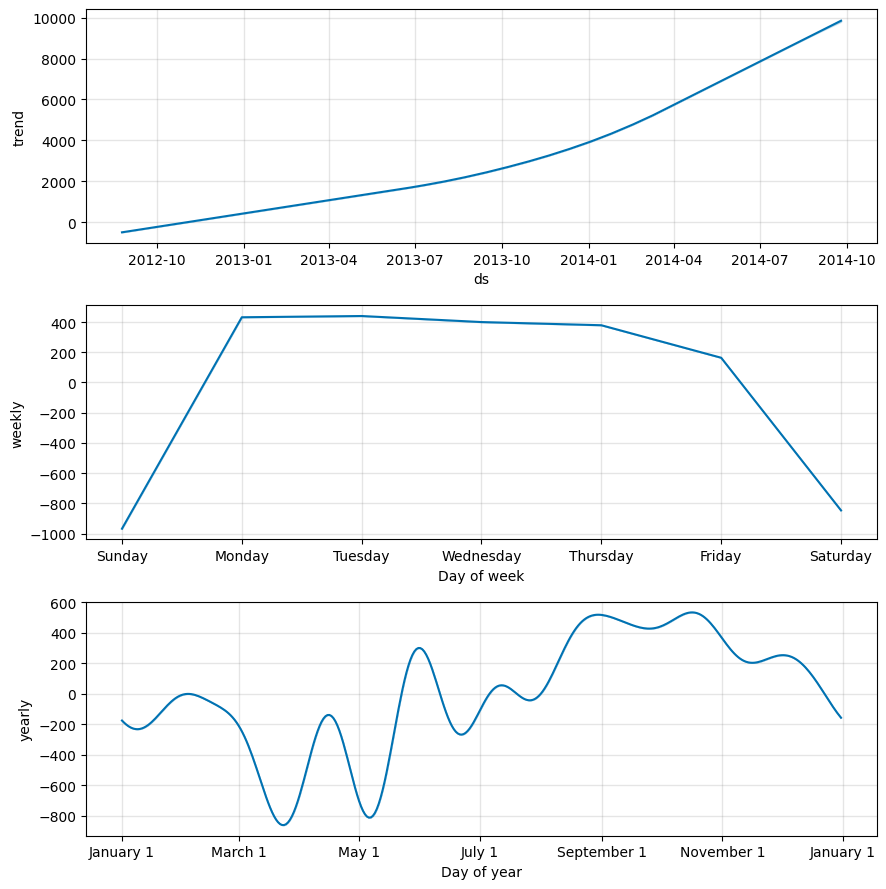

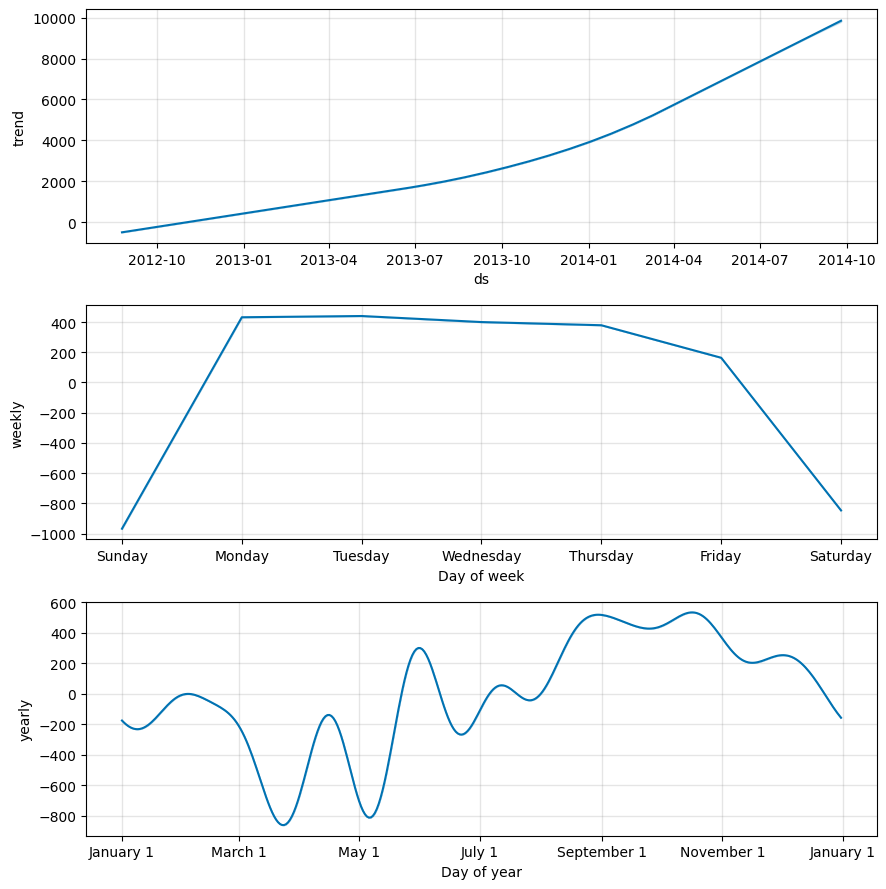

In [30]:
model2.plot_components(forecast2)

In [31]:
pred2 = forecast2.iloc[-60:, :]

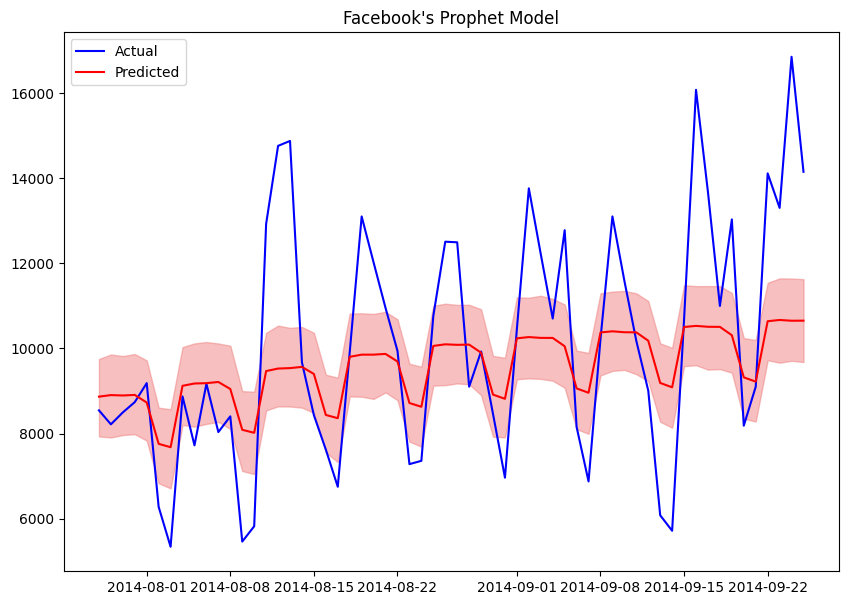

In [32]:
plt.figure(figsize=(10,7))
plt.title("Facebook's Prophet Model")
plt.plot(test['ds'], test['y'], label='Actual', color='blue')  # Added label for actual values
plt.plot(pred2['ds'], pred2['yhat'], color='red', label='Predicted')  # Predicted values in red
plt.fill_between(pred2['ds'], pred2['yhat_lower'], pred2['yhat_upper'], color='lightcoral', alpha=0.5)  # Light red shading

plt.legend()  # Show legend
plt.show()

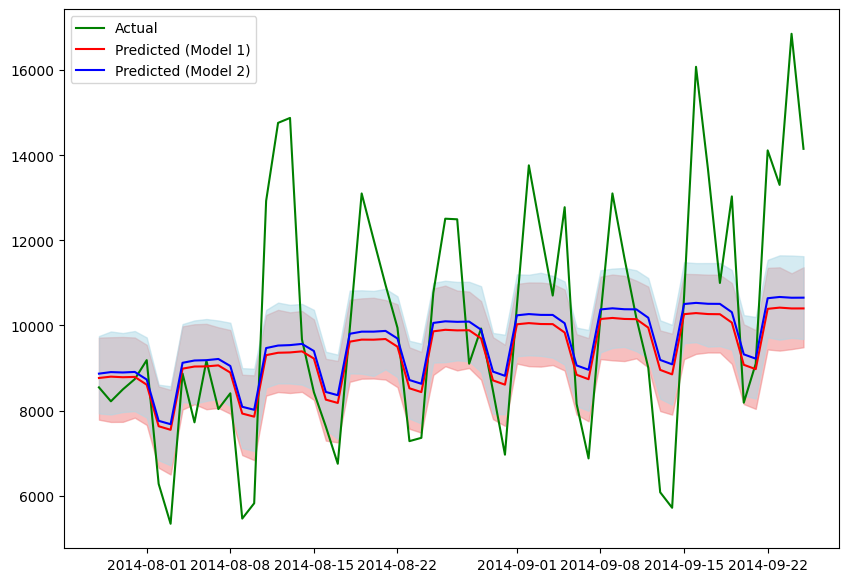

In [33]:
plt.figure(figsize=(10,7))
plt.plot(test['ds'], test['y'], label='Actual', color='green')  # Added label for actual values
plt.plot(pred['ds'], pred['yhat'], color='red', label='Predicted (Model 1)')  # Predicted values in red
plt.fill_between(pred['ds'], pred['yhat_lower'], pred['yhat_upper'], color='lightcoral', alpha=0.5)  # Light red shading
plt.plot(pred2['ds'], pred2['yhat'], color='blue', label='Predicted (Model 2)')  # Predicted values in red
plt.fill_between(pred2['ds'], pred2['yhat_lower'], pred2['yhat_upper'], color='lightblue', alpha=0.5)  # Light red shading
plt.legend()  # Show legend
plt.show()

Looks like the second model has slightly improved from the previous, but not significantly better.
Although the values are not exactly close to the test, we can see that our models are generalizing based on the trend. 

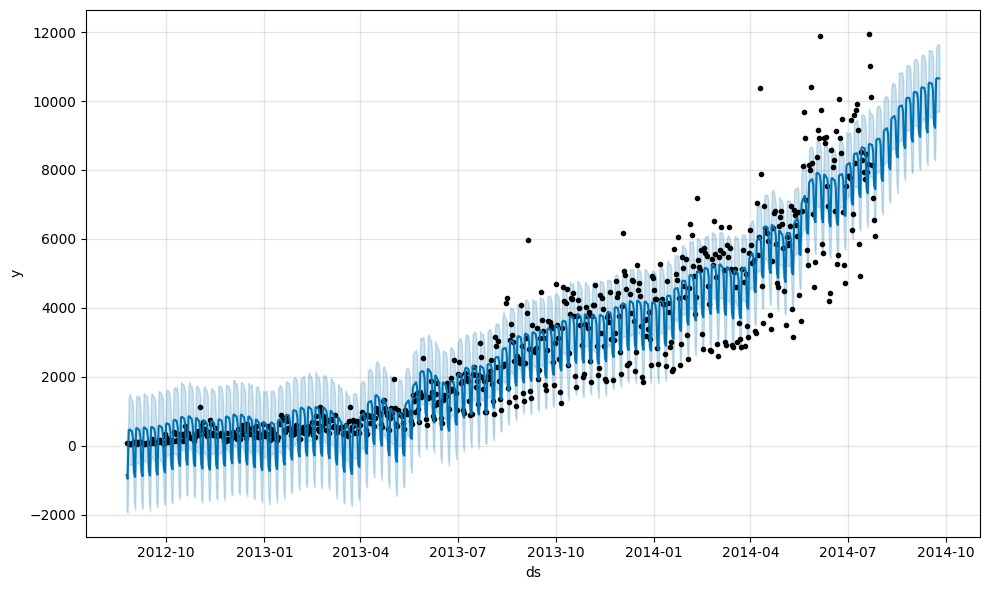

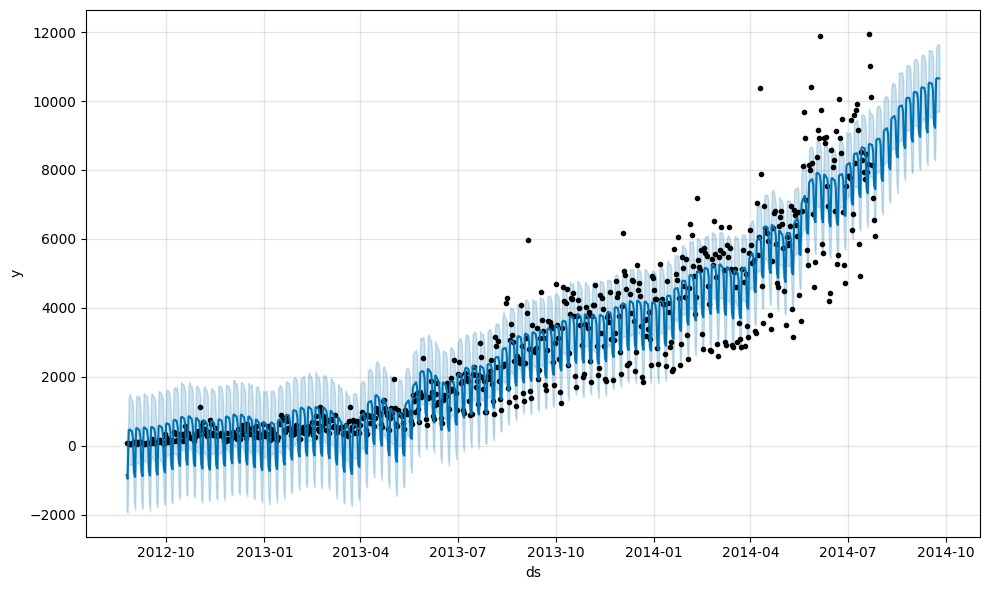

In [34]:
model2.plot(forecast2)

# Documentation for Prophet

In [35]:
help(Prophet)

Help on class Prophet in module prophet.forecaster:

class Prophet(builtins.object)
 |  Prophet(growth='linear', changepoints=None, n_changepoints=25, changepoint_range=0.8, yearly_seasonality='auto', weekly_seasonality='auto', daily_seasonality='auto', holidays=None, seasonality_mode='additive', seasonality_prior_scale=10.0, holidays_prior_scale=10.0, changepoint_prior_scale=0.05, mcmc_samples=0, interval_width=0.8, uncertainty_samples=1000, stan_backend=None, scaling: str = 'absmax', holidays_mode=None)
 |  
 |  Prophet forecaster.
 |  
 |  Parameters
 |  ----------
 |  growth: String 'linear', 'logistic' or 'flat' to specify a linear, logistic or
 |      flat trend.
 |  changepoints: List of dates at which to include potential changepoints. If
 |      not specified, potential changepoints are selected automatically.
 |  n_changepoints: Number of potential changepoints to include. Not used
 |      if input `changepoints` is supplied. If `changepoints` is not supplied,
 |      then n_